In [34]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from multiprocessing import Pool

## Reference : A Simulation Study on the Activation of Cardiac CaMKII delta-Isoform and Its Regulation by Phosphatases

Chiba H, Schneider NS, Matsuoka S, Noma A

Biophys J. 2008 Sep 01; 95(5) 2139-2149

DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018

In [52]:
"""
Reference: 
A Simulation Study on the Activation of Cardiac CaMKIId-Isoform and ItsRegulation by Phosphatases
Chiba et. al
DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018
"""

# Calmodulin model
def get_v_ca(kf, kb, ca, a ,b):
    """ a + Ca <-> b """
    return -kf * ca * a + kb * b


def get_rates_cam_ca(cam_cas, ca, cam_total, k1, km1, k2, km2, k3, km3, k4, km4):
    """ returns dCaMCai /dt """
    cam = cam_total - cam_cas[0] - cam_cas[1] - cam_cas[2] - cam_cas[3]
    ca1 = get_v_ca(k1, km1, ca, cam, cam_cas[0])
    ca2 = get_v_ca(k2, km2, ca, cam_cas[0], cam_cas[1])
    ca3 = get_v_ca(k3, km3, ca, cam_cas[1], cam_cas[2])
    ca4 = get_v_ca(k4, km4, ca, cam_cas[2], cam_cas[3])
    
    return [-ca1 + ca2, -ca2 + ca3, -ca3 + ca4, -ca4]


def get_rates_camkii(camkiis, camca4, ca, camkii_total, atp, pp1, k_asso, k_disso, k_disso_ca, k_disso2, k_disso_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    """ CaMKII model """
    
    camkii_camca4 = camkiis[0]
    camkii_p_camca4 = camkiis[1]
    camkii_p = camkiis[2]
    camkii = camkii_total - camkii_camca4 - camkii_p_camca4 - camkii_p
    
    # Association of CaMKII and CaMCa4
    a1 = k_asso * camkii * camca4
    
    # Dissociation of CaMKII and CaMCa4
    km_cam_portion = 1 / (1 + (ca / km_cam)**3)
    a2 = (k_disso * (1 - km_cam_portion) + k_disso_ca * km_cam_portion) * camkii_camca4
    
    # Autophosphorylation of CaMKII subunits
    p = 1 - (camkii / camkii_total)**2
    b1 = kcat * p * (atp / (atp + km_atp)) * camkii_camca4
    
    # Dephosphorylation by phosphorylase (PP1)
    b2 = kcat_pp1 * pp1 * (camkii_p_camca4 / (km_pp1 + camkii_p_camca4))
    d1 = kcat_pp1 * pp1 * (camkii_p / (km_pp1 + camkii_p))
    
    # Dissociation of CaMKII-p and CaMCa4 (1000x slower)
    c1 = (k_disso2 * (1 - km_cam_portion) + k_disso_ca2 * km_cam_portion) * camkii_p_camca4
    
    # Association of CaMKII-p and CaMCa4
    c2 = k_asso * camkii_p * camca4
    
    v1 = a1 - a2
    v2 = b1 - b2
    v3 = c2 - c1
    v4 = -d1
    return [a1 - a2 - b1 + b2, b1 - b2 -c1 + c2, c1 - c2 -d1]


def get_rates_phospho(camkiis, camkii_total, target, kcat, kd):
    """ Get phosphorylation rates by CaMKII """
    active_camkii = (camkiis[0] + camkiis[1] + camkiis[2]) / camkii_total
    return [-kcat * target * active_camkii + kd * (1 - target)]


def get_steady_state_phospho(camkiis, camkii_total, kcat, kd):
    """ Get active (unphosphorylated) targets fraction """
    active_camkii = (camkiis[0] + camkiis[1] + camkiis[2]) / camkii_total
    return kd / (kd + kcat * active_camkii)


def rhs(t, y, ca, cam_total, k1, km1, k2, km2, k3, km3, k4, km4, 
        camkii_total, atp, pp1, k_asso, k_disso, k_disso_ca, k_disso2, k_disso_ca2, 
        km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    cam_cas = y[:4]
    camca4 = cam_cas[-1]
    camkiis = y[4:7]
    # complex1 = y[7]
    # ck_mito = y[8]
    v_cam_ca = get_rates_cam_ca(cam_cas, ca, cam_total, k1, km1, k2, km2, k3, km3, k4, km4)
    v_camkii = get_rates_camkii(camkiis, camca4, ca, camkii_total, atp, pp1, k_asso, k_disso, k_disso_ca, k_disso2, k_disso_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1)
    # v_complex1 = get_rates_phospho(camkiis, camkii_total, complex1, kcat_complex1, kd_complex1)
    # v_ck_mito = get_rates_phospho(camkiis, camkii_total, ck_mito, kcat_ck_mito, kd_ck_mito)
    return v_cam_ca + v_camkii # + v_complex1 + v_ck_mito  # Merge lists


# Reference constants from the original paper
K1 = 2.5
KM1 = KM2 = 0.05
K2 = 88.25
K3 = 12.5
KM3 = KM4 = 1.25
K4 = 250

K_ASSO = 2.1
K_DISSO_ALPHA = 1.4E-4
K_DISSO_DELTA = 0.5 * K_DISSO_ALPHA
K_DISSO_CA_ALPHA = 1.9E-3
K_DISSO_CA_DELTA = 0.5 * K_DISSO_CA_ALPHA
K_DISSO2_ALPHA = K_DISSO_ALPHA * 1e-3
K_DISSO2_DELTA = K_DISSO_DELTA * 1e-3
K_DISSO2_CA_ALPHA = K_DISSO_CA_ALPHA * 1e-3
K_DISSO2_CA_DELTA = K_DISSO_CA_DELTA * 1e-3
KM_CAM = 3E-5
KCAT_0_ALPHA = 1E-5
KCAT_0_DELTA = 6 * KCAT_0_ALPHA
KCAT_30_ALPHA = 30 * KCAT_0_ALPHA
KCAT_30_DELTA = 6 * KCAT_30_ALPHA
KCAT_37_ALPHA = 3 * KCAT_30_ALPHA
KCAT_37_DELTA = 6 * KCAT_37_ALPHA
KM_ATP = 19.1E-3
KCAT_PP1 = 1.72E-3
KM_PP1 = 11.0E-3

# Rate contants we added
KCAT_COMPLEX1 = 1e-2
KD_COMPLEX1 = 1e-2
KCAT_CK_MITO = 1e-2
KD_CK_MITO = 1e-2

# Substance concentrations
CAM_TOTAL = 6e-3
PP1 = 0.001E-3
CAMKII_TOTAL = 0.1E-3
ATP = 0.1

# Initial conditions
y0 = [0.0, 0.0, 0.0, 0.0] + [0.0, 0.0, 0.0]

# Other constants
T_END = 2000
DELTA = 0.02

# Calcium ranges (from the author)
ca_concs = np.logspace(-4, -1, num=31)

# Params for the ODE
params = { 'cam_total': CAM_TOTAL,
           'k1': K1,
           'km1': KM1,
           'k2': K2,
           'km2': KM2,
           'k3': K3,
           'km3': KM3,
           'k4': K4,
           'km4': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_asso': K_ASSO,
           'k_disso': K_DISSO_DELTA,
           'k_disso_ca': K_DISSO_CA_DELTA,
           'k_disso2': K_DISSO2_DELTA,
           'k_disso_ca2': K_DISSO2_CA_DELTA,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}


# Ranges are 6 orders of magnitude apart, except for some linearly-spaced ones or strictly constant ones
param_ranges = {name: params[name] * np.logspace(-3, 3, num=31) for name in params}
param_ranges['atp'] = np.linspace(0, 1, num=31)

# Relative sensitivity analysis

$Sensitivity = \frac{ \frac{dP}{P}}{ \frac{dS}{S}}$

* In = Parameter(s)

* Out = Unphosphorylated proportion of CaMKII targets (complex I, mitochondrial creatine kinase)

Varying one parameter across 8 orders of magnitude at a time, plus varying calcium concentration, yielding a 2D sensitivity heat map.

In [30]:
def get_output(solution, params):
    activated = np.sum(solution.y[4:7]) / params['camkii_total']
    return activated


def get_mtck(activated):
    return KD_CK_MITO / (KD_CK_MITO + KCAT_CK_MITO * activated)


activated = np.array([get_output(solve_ivp(lambda t, y: rhs(t, y, ca, **params), (0, T_END), y0, t_eval=[T_END]), params) for ca in ca_concs])
activated_after = np.array([get_output(solve_ivp(lambda t, y: rhs(t, y, ca * (1 + DELTA), **params), (0, T_END), y0, t_eval=[T_END]), params) for ca in ca_concs])
mtck = get_mtck(activated)
mtck_after = get_mtck(activated_after)

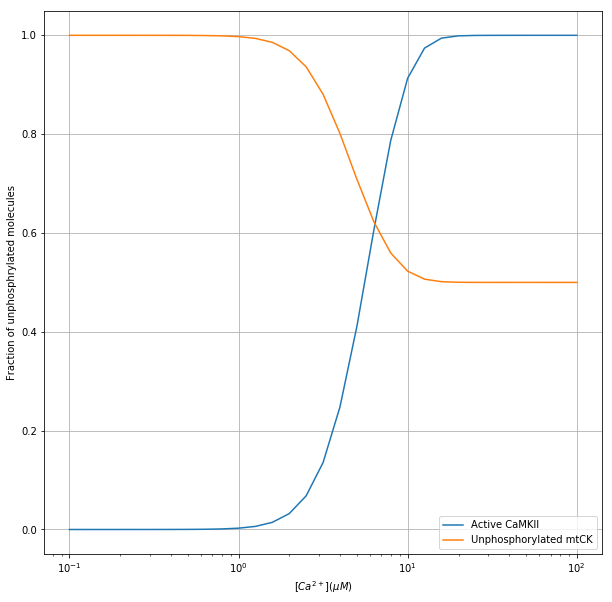

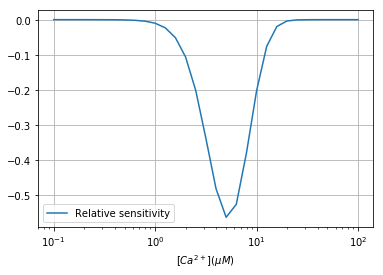

In [31]:
# Recreate Fig. 2, i.e steady-state response of CaMKII to calcium; dynamic range: Ca = 10^-3 ~ 10^-2
plt.figure(figsize=(10, 10))
plt.semilogx(ca_concs * 1e3, activated, label='Active CaMKII')
plt.semilogx(ca_concs * 1e3, mtck, label='Unphosphorylated mtCK')
plt.xlabel(r'$[Ca^{2+}]( \mu M)$')
plt.ylabel('Fraction of unphosphrylated molecules')
plt.legend(loc='best')
plt.grid(True)

sensitivity = (mtck_after - mtck) / (DELTA * mtck)

plt.figure()
plt.semilogx(ca_concs * 1e3 , sensitivity, label='Relative sensitivity')
plt.xlabel(r'$[Ca^{2+}]( \mu M)$')
plt.legend(loc='best')
plt.grid(True)

(Upper figure) The simulated response of activated CaMKII to calcium is similar to that in the previous study.

(Lower figure) A peak of relative sensitivity was noted between 1 $\mu M$ and 10 $\mu M$, in the dynamic range.

In [59]:
def calc_sensitivities(param_original, param_name, param_val, ca, rhs, y0, T_END=2000, DELTA=0.02):
    """ Generalized sensitivity map function """
    local_params = param_original.copy()
    local_params[param_name] = param_val
    activated = np.sum(odeint(lambda y, t: rhs(t, y, ca, **local_params), y0, [0, T_END], rtol=1e-8, atol=1e-8, mxstep=5000000)[-1][4:7]) / local_params['camkii_total']
    # activated = get_output(solve_ivp(lambda t, y: rhs(t, y, ca, **local_params), (0, T_END), y0, t_eval=[T_END], method='LSODA', rtol=1e-8, atol=1e-8), local_params)
    mtck = get_mtck(activated)
    local_params[param_name] = param_val * (1 + DELTA)
    # activated_after = get_output(solve_ivp(lambda t, y: rhs(t, y, ca, **local_params), (0, T_END), y0, t_eval=[T_END], method='LSODA', rtol=1e-8, atol=1e-8), local_params)
    activated_after = np.sum(odeint(lambda y, t: rhs(t, y, ca, **local_params), y0, [0, T_END], rtol=1e-8, atol=1e-8, mxstep=5000000)[-1][4:7]) / local_params['camkii_total']
    mtck_after = get_mtck(activated_after)
    sensitivity = (mtck_after - mtck) / (DELTA * mtck)
    return sensitivity

In [66]:
def plot_sensitivities(sensitivities, ca_concs, param_ranges, param_name, log_scale=True):
    """ Plot sensitivity map """
    plt.figure()
    min_sense = np.min(sensitivities)
    max_sense = np.max(sensitivities)
    sense_range = max(abs(min_sense), abs(max_sense))
    plt.pcolormesh(ca_concs * 1e3, param_ranges[param_name], sensitivities, cmap=plt.cm.bwr, vmax=sense_range, vmin=-sense_range)
    plt.xlabel(r'$[Ca^{2+}]( \mu M )$')
    plt.xscale('log')
    if log_scale:
        plt.yscale('log')
    plt.ylabel(param_name.upper())
    return plt.colorbar()

The code was running on Python 3.6 in the Jupyter notebook on a workstation with dual Xeon E5-2620 CPUs.

In [60]:
# Generator of arguments
args = {name: [(params, name, param_val, ca, rhs, y0, T_END, 0.02) for param_val in param_ranges[name] for ca in ca_concs] for name in params}

In [61]:
# Multiprocessing (using all CPU cores)
pool = Pool()
param_sensitivities = {}
for name in params:
    param_sensitivities[name] = np.array(pool.starmap(calc_sensitivities, args[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
pool.close()
print('Finished')

cam_total is completed.
k1 is completed.
km1 is completed.
k2 is completed.
km2 is completed.
k3 is completed.
km3 is completed.
k4 is completed.
km4 is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_asso is completed.
k_disso is completed.
k_disso_ca is completed.
k_disso2 is completed.
k_disso_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


/home/sosiristseng/anaconda3/envs/cupy/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


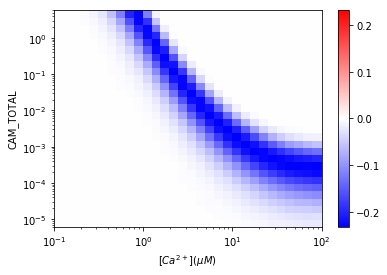

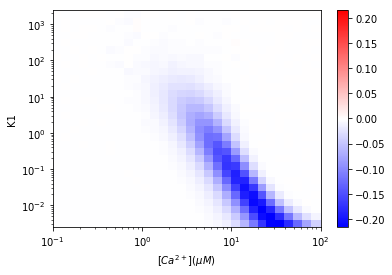

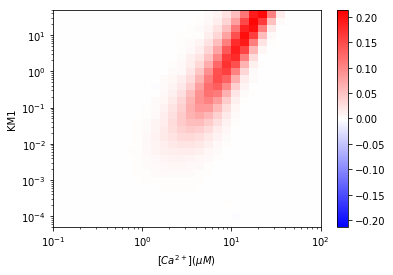

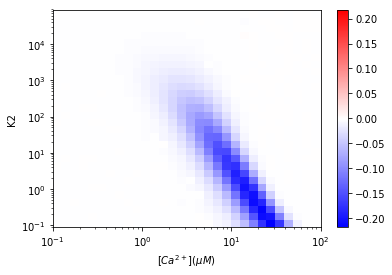

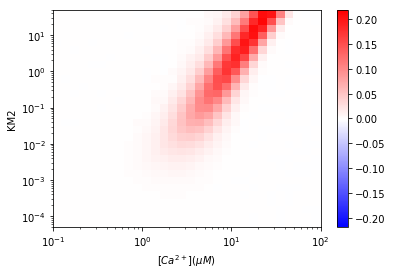

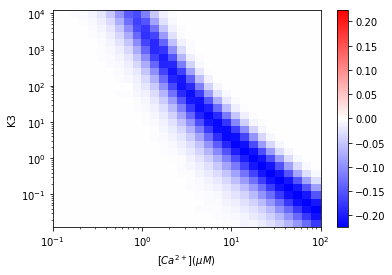

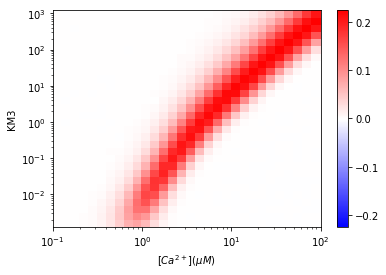

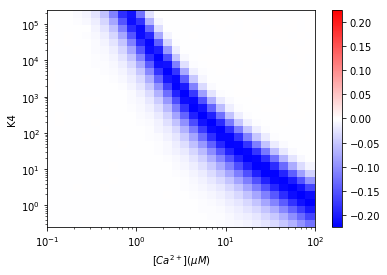

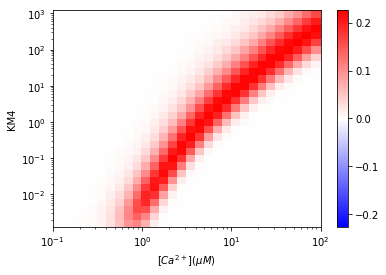

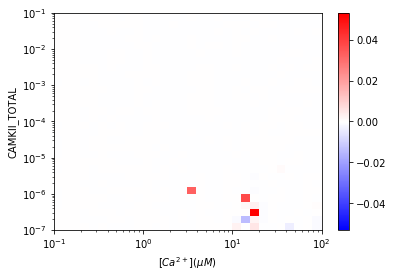

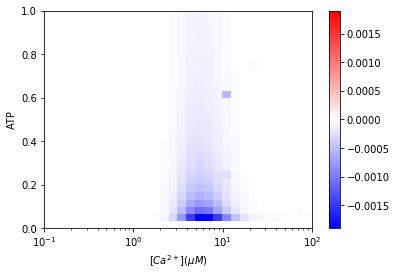

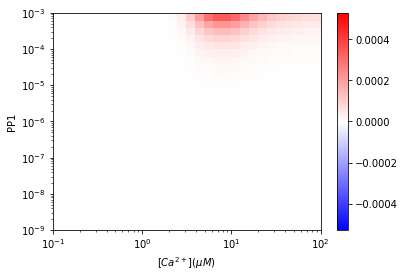

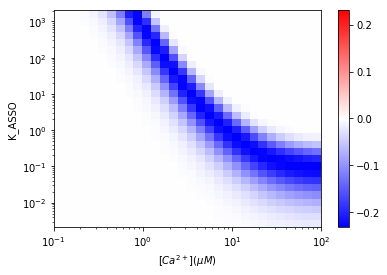

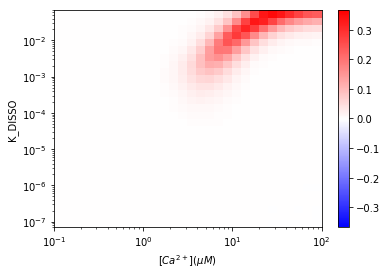

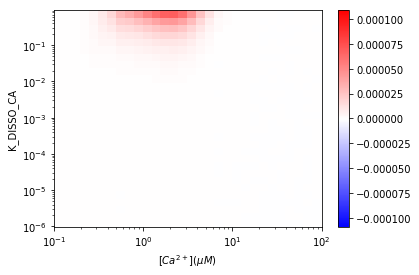

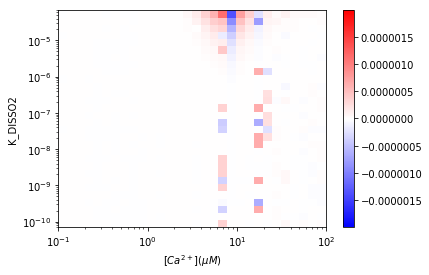

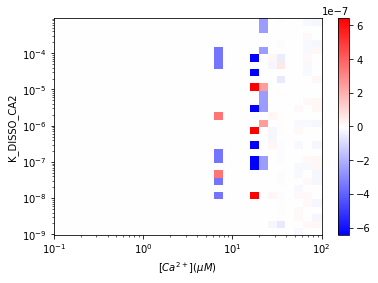

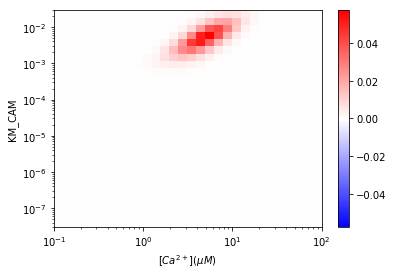

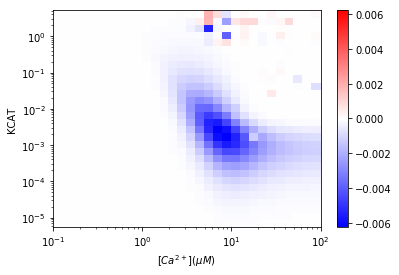

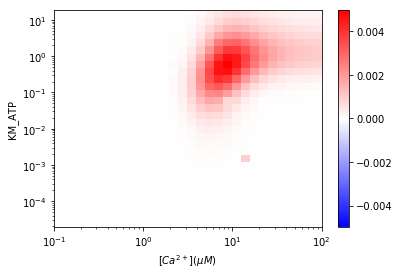

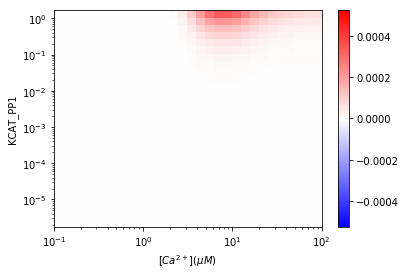

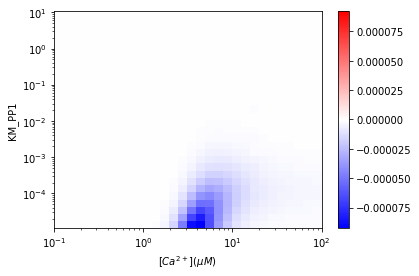

In [67]:
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))